[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/robmarkcole/satellite-imagery-projects/blob/main/ViT_classification/huggingface_ViT_image_classification_eurosat.ipynb)


In [ ]:
%%capture

! pip install datasets transformers

## Load a dataset

Let's start by loading a small image classification dataset and taking a look at its structure.


In [ ]:
from datasets import load_dataset

ds = load_dataset("nielsr/eurosat-demo", split="train")
ds = ds.train_test_split(test_size=0.1)
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2700
    })
})

Let's take a look at an example

1. `image`: A PIL Image
1. `label`: A [`datasets.ClassLabel`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel) feature, which we'll see as an integer representation of the label for a given example. (Later we'll see how to get the string class names, don't worry)

In [ ]:
ex = ds['train'][1]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=64x64 at 0x7FC4439178D0>,
 'label': 0}

Let's take a look at the image 👀

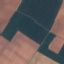

In [ ]:
image = ex['image']
image

Thats definitely a leaf! But what kind? 😅

Since the `'labels'` feature of this dataset is a `datasets.features.ClassLabel`, we can use it to lookup the corresponding name for this example's label ID.

First, lets access the feature definition for the `'labels'`.

In [ ]:
labels = ds['train'].features['label']
labels

ClassLabel(num_classes=10, names=['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake'], id=None)

In [ ]:
ds['train']

Dataset({
    features: ['image', 'label'],
    num_rows: 24300
})

Now, lets print out the class label for our example. We'll do that by using the [`int2str`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) function of `ClassLabel`, which, as the name implies, lets us pass the int representation of the class to look up the string label.

In [ ]:
labels.int2str(ex['label'])

'AnnualCrop'

Turns out the leaf shown above is infected with Bean Rust, a serious disease in bean plants. 😢

Let's write a function that'll display a grid of examples from each class so we can get a better idea of what we're working with.

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

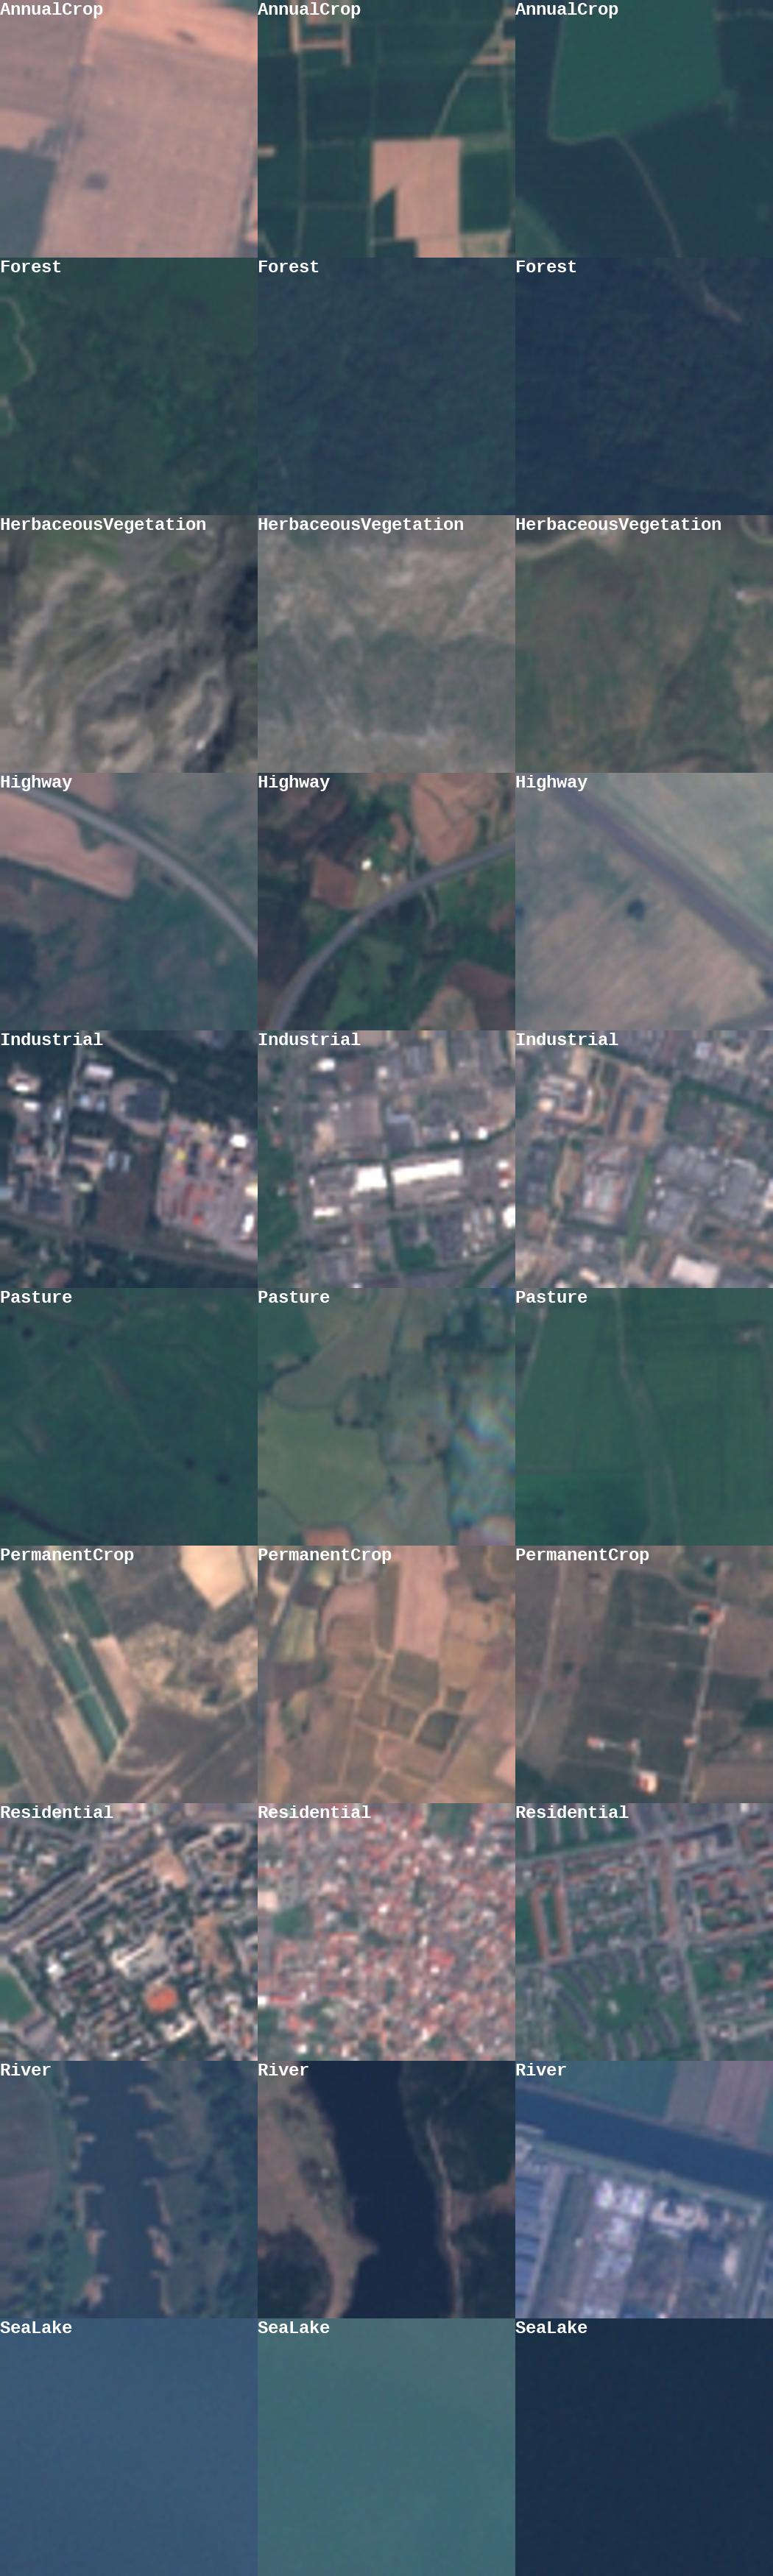

In [ ]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

## Loading ViT Feature Extractor

Now that we know what our images look like and have a better understanding of the problem we're trying to solve, let's see how we can prepare these images for our model. 

When ViT models are trained, specific transformations are applied to images being fed into them. Use the wrong transformations on your image and the model won't be able to understand what it's seeing! 🖼 ➡️ 🔢

To make sure we apply the correct transformations, we will use a [`ViTFeatureExtractor`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=classlabel#datasets.ClassLabel.int2str) initialized with a configuration that was saved along with the pretrained model we plan to use. In our case, we'll be using the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) model, so lets load its feature extractor from the 🤗 Hub.

In [ ]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

If we print a feature extractor, we can see its configuration.

In [ ]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "size": 224
}

To process an image, simply pass it to the feature extractor's call function. This will return a dict containing `pixel values`, which is the numeric representation of your image that we'll pass to the model.

We get a numpy array by default, but if we add the `return_tensors='pt'` argument, we'll get back `torch` tensors instead.


In [ ]:
feature_extractor(image, return_tensors='pt')

{'pixel_values': tensor([[[[ 0.0745,  0.0745,  0.0745,  ..., -0.0431,  0.0353,  0.0353],
          [ 0.0745,  0.0745,  0.0745,  ..., -0.0431,  0.0353,  0.0353],
          [ 0.0745,  0.0745,  0.0745,  ..., -0.0431,  0.0431,  0.0431],
          ...,
          [ 0.3490,  0.3490,  0.3490,  ..., -0.6471, -0.6471, -0.6471],
          [ 0.3569,  0.3569,  0.3569,  ..., -0.6471, -0.6471, -0.6471],
          [ 0.3569,  0.3569,  0.3569,  ..., -0.6471, -0.6471, -0.6471]],

         [[-0.2157, -0.2157, -0.2157,  ..., -0.1373, -0.0745, -0.0745],
          [-0.2157, -0.2157, -0.2157,  ..., -0.1373, -0.0745, -0.0745],
          [-0.2157, -0.2157, -0.2157,  ..., -0.1373, -0.0745, -0.0745],
          ...,
          [-0.0196, -0.0196, -0.0196,  ..., -0.4510, -0.4510, -0.4510],
          [-0.0196, -0.0196, -0.0196,  ..., -0.4510, -0.4510, -0.4510],
          [-0.0196, -0.0196, -0.0196,  ..., -0.4510, -0.4510, -0.4510]],

         [[-0.2784, -0.2784, -0.2784,  ..., -0.1451, -0.0824, -0.0824],
          [-0

## Processing the Dataset

Now that we know how to read in images and transform them into inputs, let's write a function that will put those two things together to process a single example from the dataset.

In [ ]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='pt')
    inputs['label'] = example['label']
    return inputs

In [ ]:
process_example(ds['train'][0])

{'pixel_values': tensor([[[[ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3882,  0.3804,  0.3804],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3804,  0.3647,  0.3647],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3804,  0.3647,  0.3647]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          [ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          [ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          ...,
          [ 0.3725,  0.3725,  0.3725,  ...,  0.0353,  0.0196,  0.0196],
          [ 0.3647,  0.3647,  0.3647,  ...,  0.0275,  0.0118,  0.0118],
          [ 0.3647,  0.3647,  0.3647,  ...,  0.0275,  0.0118,  0.0118]],

         [[ 0.3255,  0.3255,  0.3255,  ...,  0.3020,  0.3098,  0.3098],
          [ 0

While we could call `ds.map` and apply this to every example at once, this can be very slow, especially if you use a larger dataset. Instead, we'll apply a ***transform*** to the dataset. Transforms are only applied to examples as you index them.

First, though, we'll need to update our last function to accept a batch of data, as that's what `ds.with_transform` expects.

In [ ]:
# ds = load_dataset('beans')

def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

We can directly apply this to our dataset using `ds.with_transform(transform)`.

In [ ]:
prepared_ds = ds.with_transform(transform)

Now, whenever we get an example from the dataset, our transform will be 
applied in real time (on both samples and slices, as shown below)

In [ ]:
prepared_ds['train'][0:2]

{'pixel_values': tensor([[[[ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9922,  0.9922,  0.9922,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3882,  0.3804,  0.3804],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3804,  0.3647,  0.3647],
          [ 0.9843,  0.9843,  0.9843,  ...,  0.3804,  0.3647,  0.3647]],

         [[ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          [ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          [ 0.4824,  0.4824,  0.4824,  ...,  0.4510,  0.4510,  0.4510],
          ...,
          [ 0.3725,  0.3725,  0.3725,  ...,  0.0353,  0.0196,  0.0196],
          [ 0.3647,  0.3647,  0.3647,  ...,  0.0275,  0.0118,  0.0118],
          [ 0.3647,  0.3647,  0.3647,  ...,  0.0275,  0.0118,  0.0118]],

         [[ 0.3255,  0.3255,  0.3255,  ...,  0.3020,  0.3098,  0.3098],
          [ 0

# Training and Evaluation

The data is processed and we are ready to start setting up the training pipeline. We will make use of 🤗's Trainer, but that'll require us to do a few things first:

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy. We should define a compute_metrics function accordingly.

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the evaluation data and verify that it has indeed learned to correctly classify our images.

### Define our data collator

Batches are coming in as lists of dicts, so we just unpack + stack those into batch tensors.

We return a batch `dict` from our `collate_fn` so we can simply `**unpack` the inputs to our model later. ✨

In [ ]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

### Define an evaluation metric

Here, we load the [accuracy](https://huggingface.co/metrics/accuracy) metric from `datasets`, and then write a function that takes in a model prediction + computes the accuracy.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

Now we can load our pretrained model. We'll add `num_labels` on init to make sure the model creates a classification head with the right number of units. We'll also include the `id2label` and `label2id` mappings so we have human readable labels in the 🤗 hub widget if we choose to `push_to_hub`.

In [ ]:
from transformers import ViTForImageClassification

labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We're almost ready to train! The last thing we'll do before that is set up the training configuration by defining [`TrainingArguments`](https://huggingface.co/docs/transformers/v4.16.2/en/main_classes/trainer#transformers.TrainingArguments).

Most of these are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually its ideal to drop unused feature columns, as it makes it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('image' in particular) in order to create 'pixel_values'.

What I'm trying to say is that you'll have a bad time if you forget to set `remove_unused_columns=False`.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir="./vit-demo-eurosat",
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 24300
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 2700
    })
})

Now, all instances can be passed to Trainer and we are ready to start training!



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["test"],
    tokenizer=feature_extractor,
)

Using cuda_amp half precision backend


In [ ]:

train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 24300
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6076


Step,Training Loss,Validation Loss,Accuracy
100,0.461000,0.473242,0.880741
200,0.414100,0.260715,0.940741
300,0.299000,0.380792,0.874815
400,0.230900,0.264005,0.928889
500,0.231400,0.156760,0.955185
600,0.288000,0.261825,0.932222
700,0.231100,0.162508,0.948148
800,0.279400,0.433296,0.880741
900,0.148100,0.187289,0.952593
1000,0.173600,0.105947,0.967037


***** Running Evaluation *****
  Num examples = 2700
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-100
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-100/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-100/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-100/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2700
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-200
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-200/config.json
Model weights saved in ./vit-base-beans-demo-v5/checkpoint-200/pytorch_model.bin
Feature extractor saved in ./vit-base-beans-demo-v5/checkpoint-200/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 2700
  Batch size = 8
Saving model checkpoint to ./vit-base-beans-demo-v5/checkpoint-300
Configuration saved in ./vit-base-beans-demo-v5/checkpoint-300/config.json
Model weights save

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 7015430798GF
  train_loss               =       0.0967
  train_runtime            =   0:53:45.90
  train_samples_per_second =       30.131
  train_steps_per_second   =        1.884


In [ ]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 2700
  Batch size = 8


***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =       0.99
  eval_loss               =     0.0411
  eval_runtime            = 0:00:19.12
  eval_samples_per_second =    141.161
  eval_steps_per_second   =     17.671


In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'eurosat-demo',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

In [ ]:
kwargs

{'dataset': 'eurosat-demo',
 'finetuned_from': 'google/vit-base-patch16-224-in21k',
 'tags': ['image-classification', 'generated_from_trainer'],
 'tasks': 'image-classification'}

The resulting model has been shared to [nateraw/vit-base-beans](https://huggingface.co/nateraw/vit-base-beans). I'm assuming you don't have pictures of bean leaves laying around, but if you do, you can try out the model in the browser 🚀.